In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [3]:
DATA_DIR = "/kaggle/input/balanced-raf-db-dataset-7575-grayscale"

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(75, scale=(0.9, 1.0)),
    transforms.ToTensor()
])

In [5]:
test_val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])

In [6]:
train_dataset = ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transform)
val_dataset = ImageFolder(os.path.join(DATA_DIR, "val"), transform=test_val_transform)
test_dataset = ImageFolder(os.path.join(DATA_DIR, "test"), transform=test_val_transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


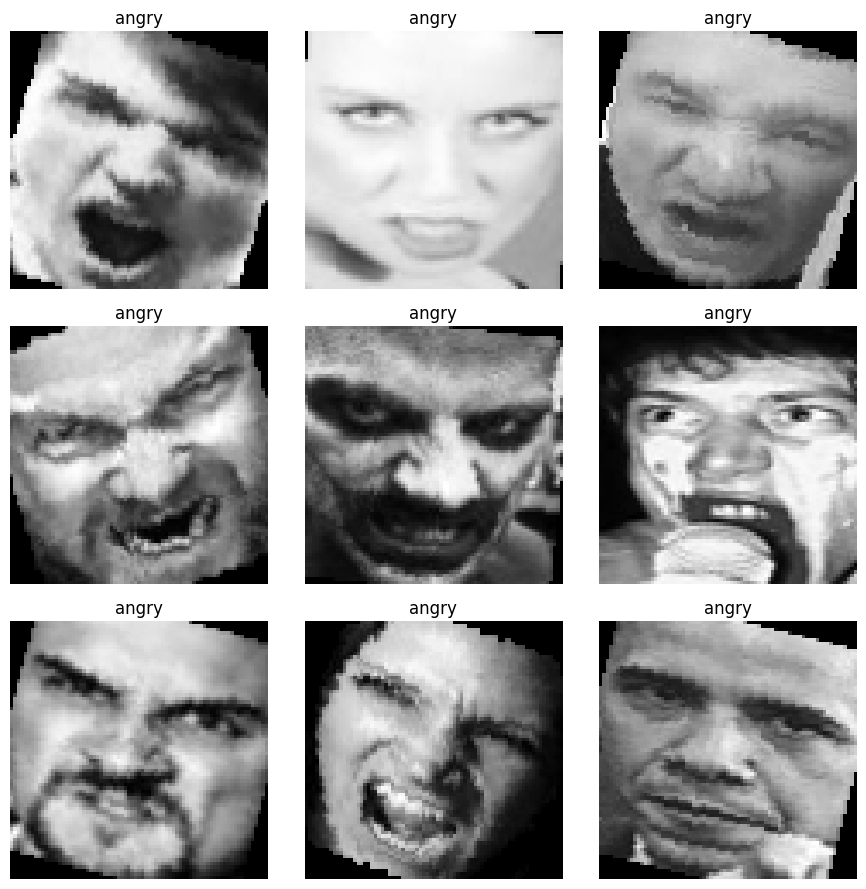

<Figure size 640x480 with 0 Axes>

In [9]:
def show_images(dataset):
    plt.figure(figsize=(9, 9))
    for i in range(9):
        img, label = dataset[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(class_names[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.savefig('samples')

show_images(train_dataset)

In [10]:
class EmotionResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = resnet18(pretrained=True)
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 7)
        )
    def forward(self, x):
        return self.base(x)

In [11]:
model = EmotionResNet().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

In [13]:
train_losses, val_accuracies, test_accuracies = [], [], []
best_val_acc = 0
patience = 3
wait = 0

In [14]:
for epoch in range(15):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    # Test
    correct = total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    test_acc = 100 * correct / total
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.2f}%, Test Acc={test_acc:.2f}%")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping triggered.")
            break

    scheduler.step(val_acc)

Epoch 1: Loss=1.3291, Val Acc=62.94%, Test Acc=63.29%
Epoch 2: Loss=0.9146, Val Acc=66.84%, Test Acc=65.45%
Epoch 3: Loss=0.7368, Val Acc=78.04%, Test Acc=78.39%
Epoch 4: Loss=0.6248, Val Acc=73.91%, Test Acc=73.35%
Epoch 5: Loss=0.5433, Val Acc=83.73%, Test Acc=83.27%
Epoch 6: Loss=0.4751, Val Acc=86.11%, Test Acc=85.38%
Epoch 7: Loss=0.4282, Val Acc=86.43%, Test Acc=86.60%
Epoch 8: Loss=0.3844, Val Acc=82.30%, Test Acc=82.40%
Epoch 9: Loss=0.3464, Val Acc=88.87%, Test Acc=88.43%
Epoch 10: Loss=0.3211, Val Acc=84.47%, Test Acc=85.02%
Epoch 11: Loss=0.2968, Val Acc=88.02%, Test Acc=87.52%
Epoch 12: Loss=0.2901, Val Acc=90.86%, Test Acc=90.23%
Epoch 13: Loss=0.2722, Val Acc=90.70%, Test Acc=90.01%
Epoch 14: Loss=0.2540, Val Acc=83.48%, Test Acc=83.63%
Epoch 15: Loss=0.2333, Val Acc=92.32%, Test Acc=92.48%


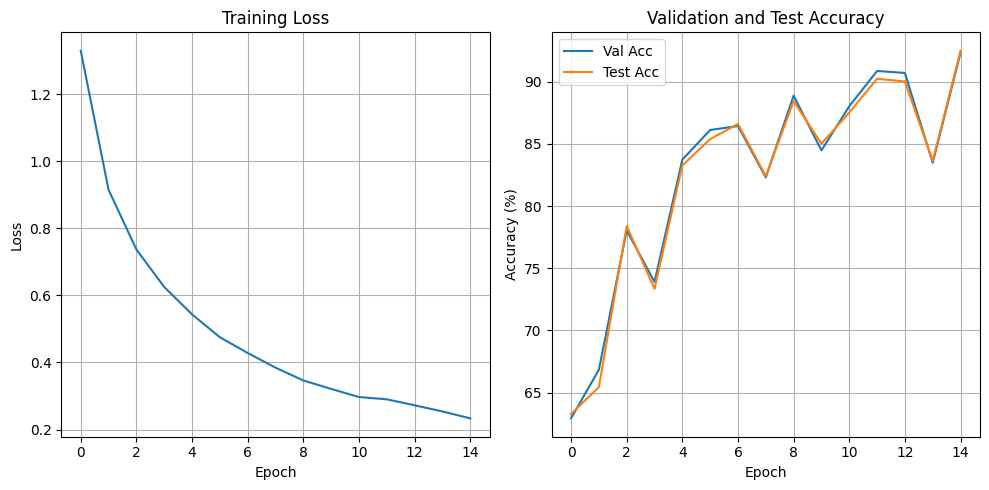

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.savefig('train_loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation and Test Accuracy")
plt.legend()
plt.grid()
plt.savefig('val_vs_test_acc')

plt.tight_layout()
plt.show()

In [18]:
wrong_samples = []

In [19]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_samples.append((images[i].cpu(), preds[i].item(), labels[i].item()))
        if len(wrong_samples) >= 9:
            break

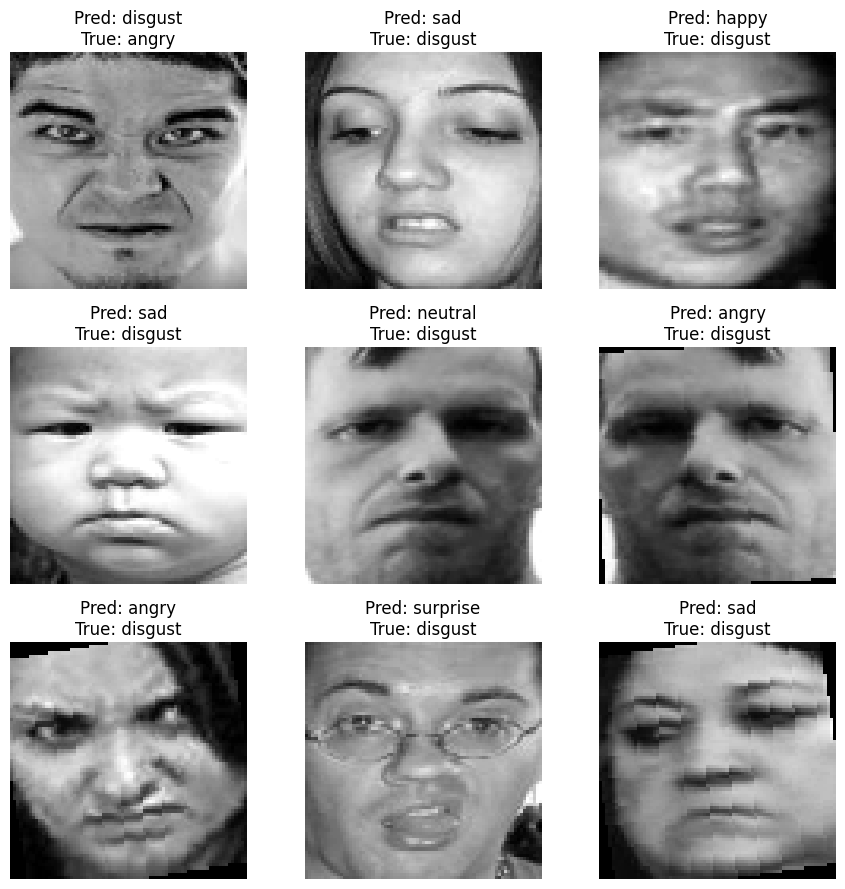

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(9, 9))
for i, (img, pred, true) in enumerate(wrong_samples[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
plt.savefig('wrongly_pred')

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

In [27]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

<Figure size 800x600 with 0 Axes>

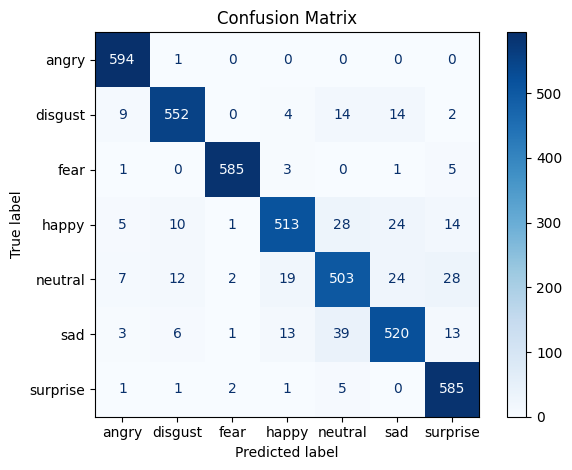

In [28]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix')
plt.show()

In [29]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

       angry       0.96      1.00      0.98       595
     disgust       0.95      0.93      0.94       595
        fear       0.99      0.98      0.99       595
       happy       0.93      0.86      0.89       595
     neutral       0.85      0.85      0.85       595
         sad       0.89      0.87      0.88       595
    surprise       0.90      0.98      0.94       595

    accuracy                           0.92      4165
   macro avg       0.92      0.92      0.92      4165
weighted avg       0.92      0.92      0.92      4165



In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

In [31]:
y_true = label_binarize(all_labels, classes=list(range(len(class_names))))
y_scores = []


In [32]:
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())

In [33]:
y_scores = np.array(y_scores)

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

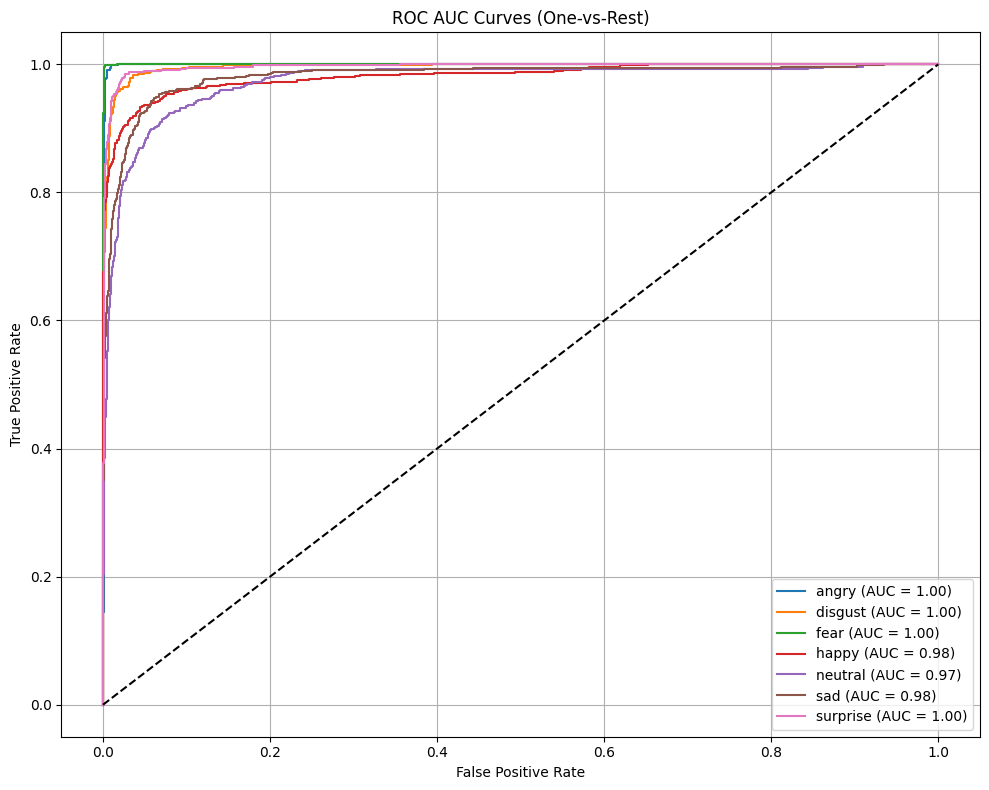

In [36]:
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC AUC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('roc_auc_curve')
plt.show()